In [1]:
# MLの基礎ライブラリ
import numpy as np
import pandas as pd
import pandas.plotting as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap  # グラフの色付け
%matplotlib inline
# 前処理
from sklearn.model_selection import train_test_split, GridSearchCV  # データ分割
from sklearn.impute import SimpleImputer  # 欠損値補完
from sklearn.preprocessing import StandardScaler  # 特徴量標準化
# 次元削減
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
# モデル
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
# スコア
from sklearn.metrics import f1_score
# バイナリオブジェクト
import pickle

In [2]:
# データフレーム
csv_name = 'csv/train.csv'
df = pd.read_csv(csv_name)

x = df.drop(columns='Survived', axis=1)
y = df.Survived

# 不要な特徴量を削除
drop_col = ['PassengerId', 'Pclass', 'Name', 'Ticket']
x = x.drop(columns=drop_col)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex       891 non-null    object 
 1   Age       714 non-null    float64
 2   SibSp     891 non-null    int64  
 3   Parch     891 non-null    int64  
 4   Fare      891 non-null    float64
 5   Cabin     204 non-null    object 
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 48.9+ KB


In [3]:
# ダミー変数化
df = pd.get_dummies(x, dummy_na=True)

# 欠損値確認
print(df.isnull().sum())

# 平均値補完
imp = SimpleImputer()
imp.fit(df)
x_col = df.columns.values
x_new = pd.DataFrame(imp.transform(df), columns=x_col)

# データ標準化
sta = StandardScaler()
X = sta.fit_transform(x_new)
x_new.sample(5)

Age             177
SibSp             0
Parch             0
Fare              0
Sex_female        0
               ... 
Cabin_nan         0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Embarked_nan      0
Length: 159, dtype: int64


,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Sex_nan,Cabin_A10,Cabin_A14,Cabin_A16,...,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Cabin_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
775,18.000000,0.0,0.0,7.7500,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,29.699118,0.0,0.0,8.4583,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
696,44.000000,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
344,36.000000,0.0,0.0,13.0000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
55,29.699118,0.0,0.0,35.5000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# 特徴量選択
est = DecisionTreeClassifier()
selector = RFE(est, 80, step=.01)
selected_x = selector.fit_transform(X, y)

# データフレームへ
x_col = x_col[selector.support_]
X = pd.DataFrame(selected_x, columns=x_col)

In [5]:
# 主成分分析
pca = PCA(n_components=2)
X = pca.fit_transform(X)
# データ分割
x_train, x_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=89)

In [6]:
# モデル辞書
models = {
    'k_neig': KNeighborsClassifier(),
    'tree': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'svc': SVC(),
    'gaus_C': GaussianProcessClassifier(),
    'gaus_NB': GaussianNB(),
}

In [7]:
%%time
# モデルの学習
for model in models.values():
    model.fit(x_train, y_train)
print('>>> learning done!')

>>> learning done!
Wall time: 821 ms


In [8]:
# モデル評価
result = []
for mo in models.values():
    train = round(mo.score(x_train, y_train), 6)
    test = round(mo.score(x_test, y_test), 6)
    result.append([train, test])
# 列と行の名前
col = ['train_score', 'test_score']
row = ['k_neig', 'tree', 'rfc', 'svc', 'gaus_C', 'gaus_NB']
# スコアをデータフレームにする
rdf = pd.DataFrame(result, columns=col, index=row)
rdf

,train_score,test_score
k_neig,0.841091,0.791045
tree,0.988764,0.772388
rfc,0.988764,0.802239
svc,0.789727,0.813433
gaus_C,0.805778,0.809701
gaus_NB,0.759230,0.753731


In [9]:
# F値の評価
result_f = []
for mo in models.values():
    train = f1_score(y_train, mo.predict(x_train))
    test = f1_score(y_test, mo.predict(x_test))
    result_f.append([train, test])
fdf = pd.DataFrame(result_f, columns=col, index=row)
fdf

,train_score,test_score
k_neig,0.783370,0.692308
tree,0.985447,0.696517
rfc,0.985447,0.722513
svc,0.720682,0.731183
gaus_C,0.738661,0.730159
gaus_NB,0.649533,0.648936


In [10]:
# 正解率の高いモデルを選択
score = 0
model_name = ''
for name, model in models.items():
    if model.score(x_test, y_test) > score:
        score = model.score(x_test, y_test)
        model_name = name
print(f'>>> Selected "{model_name}"!')

>>> Selected "svc"!


In [11]:
# # F値の高いモデルを選択
# score = 0
# name = ''
# for i in range(len(fdf.test_score)):
#     if fdf.test_score[i] > score:
#         print(fdf.test_score)
#         score = i
#         name = fdf.index(i)
# print(f'>>> Selected "{name}"!')

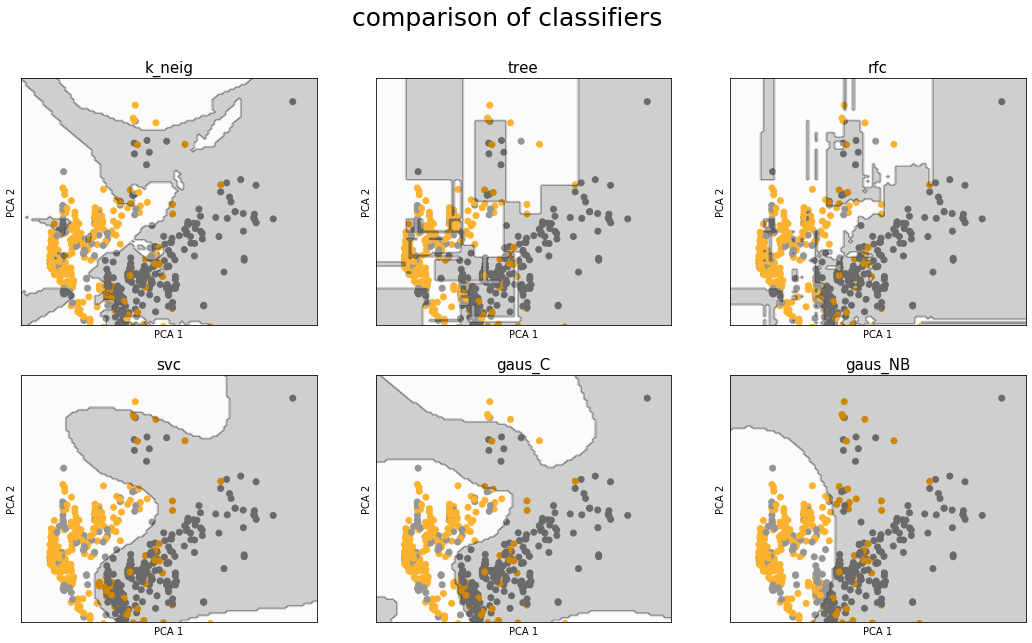

In [12]:
# 色の定義
fig, axs = plt.subplots(2, 3, figsize=(18,10))
fig.suptitle('comparison of classifiers', size=25)
cm = plt.cm.binary
cm_bright = ListedColormap(['orange', 'gray'])

# グラフの色付けエリアの定義
h = .1
x_min, x_max = X[:, 0].min() - 1, X[:, 1].max() + 1
y_min, y_max = X[:, 0].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

# グラフの色付け
def draw_graph(title, i, j, model):
    # ラベル可視化
    axs[i, j].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright)
    axs[i, j].scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright)
    # 分類エリア可視化
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[i, j].contourf(xx, yy, Z, cmap=cm, alpha=.2)
    axs[i, j].grid()
    axs[i, j].set_xlabel('PCA 1', size=10)
    axs[i, j].set_ylabel('PCA 2', size=10)
    axs[i, j].set_title(title, size=15)
    # グラフのX軸、y軸の長さ整形
    axs[i, j].set_xlim(xx.min(), xx.max())
    axs[i, j].set_ylim(yy.min(), yy.max())
    axs[i, j].set_xticks(())
    axs[i, j].set_yticks(())

# 関数の引数リスト
args = [['k_neig', 0, 0, models['k_neig']],
        ['tree', 0, 1, models['tree']],
        ['rfc', 0, 2, models['rfc']],
        ['svc', 1, 0, models['svc']],
        ['gaus_C', 1, 1, models['gaus_C']],
        ['gaus_NB', 1, 2, models['gaus_NB']]]
        
# プロット
for li in args:
    draw_graph(*li)
plt.savefig('fig_1.png')
plt.show()

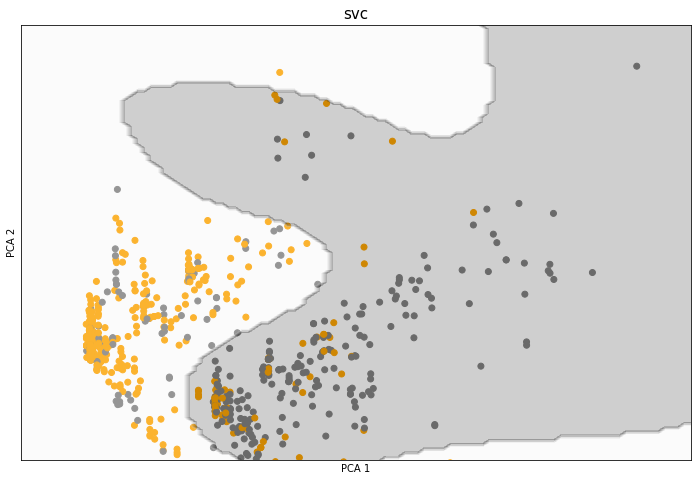

In [13]:
# 選択したモデルのグラフ
fig, ax = plt.subplots(figsize=(12,8))

# ラベル可視化
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright)
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright)
# 分類エリア可視化
Z = models[model_name].predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.2)
ax.set_xlabel('PCA 1', size=10)
ax.set_ylabel('PCA 2', size=10)
ax.set_title(model_name, size=15)
# グラフのX軸、y軸の長さ整形
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

plt.savefig('fig_2.png')
plt.show()